In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format ='svg'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import re
import statsmodels.api as sm
from typing import List
from statsmodels.tsa.ar_model import AutoReg
from itertools import dropwhile

# local imports
from helpers.sql import connect_to_db, update_database, read_db
from helpers.ar_model import transformation, transform, forecast_residual
from helpers.fama_macbeth import FamaMacbeth
from helpers.pretty_print import pretty_print_pval

In [3]:
plt.style.use('ggplot')

In [4]:
# Connect to database (downloads if not exist)
engine = connect_to_db()

# Set this to True to update database locally
update = False

if update:
    update_database()

In [5]:
# Loading data
factors = read_db(engine=engine, statement="select * from factors", idx_col="date")
risk_free_rate = read_db(
    engine=engine, statement="select * from riskfree", idx_col="date"
)
sentiment = read_db(engine=engine, statement="select * from sentiment", idx_col="date")
returns_bm_size = read_db(
    engine=engine, statement="select * from bm_size_portfolios", idx_col="date"
)
returns_industry_10 = read_db(
    engine=engine, statement='select * from "10_industry_portfolios"', idx_col="date"
)
returns_industry_49 = read_db(
    engine=engine, statement='select * from "49_industry_portfolios"', idx_col="date"
)
sentiment_sum_ar1 = read_db(
    engine=engine, statement="select * from climate_sum_ar1", idx_col="date"
)
sentiment_mean_n_ar1 = read_db(
    engine=engine, statement="select * from climate_mean_n_ar1", idx_col="date"
)


In [6]:
# Merging into one dataframe
factors_sum = pd.merge(left=factors, right=sentiment_sum_ar1, left_index=True, right_index=True)
factors_mean_n = pd.merge(left=factors, right=sentiment_mean_n_ar1, left_index=True, right_index=True)

In [7]:
# Subtracting the risk-free rate from the returns
returns_bm_size = pd.merge(
    left=returns_bm_size, right=risk_free_rate, left_index=True, right_index=True
)
returns_bm_size = returns_bm_size.apply(lambda x: x - x["rf"], axis=1)
returns_bm_size = returns_bm_size.drop(columns=["rf"])

returns_industry_10 = pd.merge(
    left=returns_industry_10, right=risk_free_rate, left_index=True, right_index=True
)
returns_industry_10 = returns_industry_10.apply(lambda x: x - x["rf"], axis=1)
returns_industry_10 = returns_industry_10.drop(columns=["rf"])

returns_industry_49 = pd.merge(
    left=returns_industry_49, right=risk_free_rate, left_index=True, right_index=True
)
returns_industry_49 = returns_industry_49.apply(lambda x: x - x["rf"], axis=1)
returns_industry_49 = returns_industry_49.drop(columns=["rf"])


In [8]:
TOPICS = [
    None,
    "aggregate_transformed_residuals",
    "weather_extremes_transformed_residuals",
    "importance_of_human_intervantion_transformed_residuals",
    "politics_transformed_residuals",
]

SIGNIFICANT_DIGITS = 5

# setting newey west lags to 7 according to Greene
# (Econometric Analysis, 7th edition, section 20.5.2, p. 960)
NEWEY_WEST = 7

# there can be some discrepencies in the gmm standard errors when annualising
# this is not the case for the normal fm errors and may be due to some numerical optimisations
# in the gmm
YEARLY_BUSINESS_DAYS: int = 250

START_DATE = '2009-10-13' # first date we have full politics UCP
#START_DATE = "2009-03-02" # the old start date - should not be used (!)
#START_DATE = "2019-09-01"  # Be aware: Large data merge 1. september 2017
END_DATE = "2019-10-01"  # Be aware: Large data merge 1. september 2017
SPLIT_DATE = "2014-01-01"

BASE_AP_MODEL = ["mkt-rf", "smb", "hml", "mom"]

# select return observations
returns = {
    "bm_size": returns_bm_size.loc[START_DATE:END_DATE],
    "10_industries": returns_industry_10.loc[START_DATE:END_DATE],
    "49_industries": returns_industry_49.loc[START_DATE:END_DATE],
}

# select factor observations
factors_sum = factors_sum.loc[START_DATE:END_DATE]
factors_mean_n = factors_mean_n.loc[START_DATE:END_DATE]


In [9]:
# annualise returns
for key, value in returns.items():
    returns[key] = value * YEARLY_BUSINESS_DAYS

# annualise factors
for factor in BASE_AP_MODEL:
    factors_sum[factor] = factors_sum[factor] * YEARLY_BUSINESS_DAYS
    factors_mean_n[factor] = factors_mean_n[factor] * YEARLY_BUSINESS_DAYS


In [10]:
# remove weekends and holidays from factors
factors_sum = factors_sum.reindex(returns_bm_size.index).dropna(how="all")
factors_mean_n = factors_mean_n.reindex(returns_bm_size.index).dropna(how="all")


# Robustness check for seeing if WE was encompassed in Pol

In [11]:
X = factors_sum[BASE_AP_MODEL].copy()

#X['weather_extremes_transformed_residuals'] = factors_sum['weather_extremes_transformed_residuals']
#X['politics_transformed_residuals'] = factors_sum['politics_transformed_residuals']
#X['aggregate_transformed_residuals'] = factors_sum['aggregate_transformed_residuals']
#X['importance_of_human_intervantion_transformed_residuals'] = factors_sum['importance_of_human_intervantion_transformed_residuals']

# there is some data missing in 2009 for `importance of human intervation` topic
# We should probably look into why this is the case
X = X.dropna()
X = X.loc[X.index > SPLIT_DATE]

display(X)

# reindex Y (only relevant in case of missing observations in factors
# i.e. for some sentiment topics
Y = returns['bm_size'].copy().loc[X.index]

# estimate and fit FM model
fm = FamaMacbeth(
    gmm_errors=True,
    n_west_lags=NEWEY_WEST,
    assets=Y,
    factors=X,
)
fm.fit()

# capture results
fm.summary

,mkt-rf,smb,hml,mom
2014-01-02,-2.200,-0.600,0.450,-0.150
2014-01-03,0.075,1.000,0.100,0.600
2014-01-06,-0.850,-1.350,0.750,-0.275
2014-01-07,1.700,0.800,-0.925,1.300
2014-01-08,0.100,0.000,-0.275,1.600
...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600
2019-09-26,-1.025,-2.450,0.300,2.025
2019-09-27,-1.550,-0.425,2.200,-1.775
2019-09-30,1.250,-0.650,-1.200,0.500


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.032462,0.075466,0.430157,0.333541,0.080740,0.402060,0.343820,1438,0.508188,0.731474
1,mkt-rf,0.081602,0.095064,0.858388,0.195339,0.096805,0.842950,0.199628,1438,0.508188,0.731474
2,smb,-0.050634,0.034627,-1.462263,0.071835,0.035421,-1.429476,0.076434,1438,0.508188,0.731474
3,hml,-0.044168,0.035959,-1.228268,0.109673,0.037143,-1.189122,0.117196,1438,0.508188,0.731474
4,mom,0.170750,0.112787,1.513906,0.065025,0.111064,1.537400,0.062098,1438,0.508188,0.731474


In [12]:
X = factors_mean_n[BASE_AP_MODEL].copy()

X['weather_extremes_transformed_residuals'] = factors_mean_n['weather_extremes_transformed_residuals']
X['politics_transformed_residuals'] = factors_mean_n['politics_transformed_residuals']

# there is some data missing in 2009 for `importance of human intervation` topic
# We should probably look into why this is the case
X = X.dropna()
X = X.loc[X.index > SPLIT_DATE]

display(X)

# reindex Y (only relevant in case of missing observations in factors
# i.e. for some sentiment topics
Y = returns['bm_size'].copy().loc[X.index]

# estimate and fit FM model
fm = FamaMacbeth(
    gmm_errors=True,
    n_west_lags=NEWEY_WEST,
    assets=Y,
    factors=X,
)
fm.fit()

# capture results
fm.summary

,mkt-rf,smb,hml,mom,weather_extremes_transformed_residuals,politics_transformed_residuals
2014-01-02,-2.200,-0.600,0.450,-0.150,0.043688,0.047098
2014-01-03,0.075,1.000,0.100,0.600,0.043491,0.047734
2014-01-06,-0.850,-1.350,0.750,-0.275,0.042412,0.047312
2014-01-07,1.700,0.800,-0.925,1.300,0.042242,0.047911
2014-01-08,0.100,0.000,-0.275,1.600,-0.902661,0.047890
...,...,...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600,-1.407046,0.778532
2019-09-26,-1.025,-2.450,0.300,2.025,0.210638,-0.510108
2019-09-27,-1.550,-0.425,2.200,-1.775,-0.365285,0.500206
2019-09-30,1.250,-0.650,-1.200,0.500,-0.570563,-0.280645


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.097125,0.076826,1.264218,0.103076,0.087887,1.105119,0.134554,1438,0.516299,0.82881
1,mkt-rf,0.014862,0.095758,0.155204,0.438330,0.102382,0.145162,0.442291,1438,0.516299,0.82881
2,smb,-0.048516,0.034525,-1.405230,0.079976,0.035783,-1.355837,0.087576,1438,0.516299,0.82881
3,hml,-0.047889,0.035856,-1.335569,0.090845,0.037151,-1.289041,0.098692,1438,0.516299,0.82881
4,mom,0.162469,0.113459,1.431969,0.076076,0.127513,1.274138,0.101307,1438,0.516299,0.82881
5,weather_extremes_transformed_residuals,0.148323,0.114566,1.294652,0.097720,0.122701,1.208811,0.113368,1438,0.516299,0.82881
6,politics_transformed_residuals,-0.245806,0.126434,-1.944142,0.025939,0.153352,-1.602890,0.054480,1438,0.516299,0.82881


## Fama Macbeth with sentiment residuals
This script produces the Fama Macbeth results with residuals.

In [13]:
def estimate_fm_for_plotting(topic):
    X = factors_mean_n[BASE_AP_MODEL].copy()
    if topic is not None:
        X[topic] = factors_mean_n[topic]

    # there is some data missing in 2009 for `importance of human intervation` topic
    # We should probably look into why this is the case
    X = X.dropna()

    display(X)

    # reindex Y (only relevant in case of missing observations in factors
    # i.e. for some sentiment topics
    Y = returns['bm_size'].copy().loc[X.index]

    # estimate and fit FM model
    fm = FamaMacbeth(
        gmm_errors=True,
        n_west_lags=NEWEY_WEST,
        assets=Y,
        factors=X,
    )
    fm.fit()

    # capture results
    return fm

In [14]:
fm_objects = []

for topic in tqdm(TOPICS):
    fm = estimate_fm_for_plotting(topic)
    fm_objects.append(fm)

  0%|          | 0/5 [00:00<?, ?it/s]

,mkt-rf,smb,hml,mom
2009-10-13,-0.550,0.125,-0.400,0.425
2009-10-14,4.325,0.425,2.925,0.550
2009-10-15,0.875,-0.725,-1.150,0.175
2009-10-16,-2.050,-0.400,-3.125,-0.225
2009-10-19,2.300,0.075,0.025,0.925
...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600
2019-09-26,-1.025,-2.450,0.300,2.025
2019-09-27,-1.550,-0.425,2.200,-1.775
2019-09-30,1.250,-0.650,-1.200,0.500


 20%|██        | 1/5 [00:39<02:38, 39.60s/it]

,mkt-rf,smb,hml,mom,aggregate_transformed_residuals
2009-10-13,-0.550,0.125,-0.400,0.425,0.284846
2009-10-14,4.325,0.425,2.925,0.550,0.112745
2009-10-15,0.875,-0.725,-1.150,0.175,0.291074
2009-10-16,-2.050,-0.400,-3.125,-0.225,0.125001
2009-10-19,2.300,0.075,0.025,0.925,-0.277755
...,...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600,0.093625
2019-09-26,-1.025,-2.450,0.300,2.025,-0.161797
2019-09-27,-1.550,-0.425,2.200,-1.775,-0.148216
2019-09-30,1.250,-0.650,-1.200,0.500,-1.338301


 40%|████      | 2/5 [01:19<01:58, 39.57s/it]

,mkt-rf,smb,hml,mom,weather_extremes_transformed_residuals
2009-10-13,-0.550,0.125,-0.400,0.425,-0.375672
2009-10-14,4.325,0.425,2.925,0.550,-0.229169
2009-10-15,0.875,-0.725,-1.150,0.175,-0.478932
2009-10-16,-2.050,-0.400,-3.125,-0.225,-0.133992
2009-10-19,2.300,0.075,0.025,0.925,-0.416154
...,...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600,-1.407046
2019-09-26,-1.025,-2.450,0.300,2.025,0.210638
2019-09-27,-1.550,-0.425,2.200,-1.775,-0.365285
2019-09-30,1.250,-0.650,-1.200,0.500,-0.570563


 60%|██████    | 3/5 [01:58<01:19, 39.65s/it]

,mkt-rf,smb,hml,mom,importance_of_human_intervantion_transformed_residuals
2009-10-13,-0.550,0.125,-0.400,0.425,0.673408
2009-10-14,4.325,0.425,2.925,0.550,0.205307
2009-10-15,0.875,-0.725,-1.150,0.175,0.232999
2009-10-16,-2.050,-0.400,-3.125,-0.225,-0.232440
2009-10-19,2.300,0.075,0.025,0.925,-0.031249
...,...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600,-0.467882
2019-09-26,-1.025,-2.450,0.300,2.025,-0.025653
2019-09-27,-1.550,-0.425,2.200,-1.775,0.218963
2019-09-30,1.250,-0.650,-1.200,0.500,-0.593189


 80%|████████  | 4/5 [02:38<00:39, 39.78s/it]

,mkt-rf,smb,hml,mom,politics_transformed_residuals
2009-10-13,-0.550,0.125,-0.400,0.425,0.348664
2009-10-14,4.325,0.425,2.925,0.550,-0.316491
2009-10-15,0.875,-0.725,-1.150,0.175,0.125112
2009-10-16,-2.050,-0.400,-3.125,-0.225,0.097296
2009-10-19,2.300,0.075,0.025,0.925,-0.242123
...,...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600,0.778532
2019-09-26,-1.025,-2.450,0.300,2.025,-0.510108
2019-09-27,-1.550,-0.425,2.200,-1.775,0.500206
2019-09-30,1.250,-0.650,-1.200,0.500,-0.280645


100%|██████████| 5/5 [03:18<00:00, 39.67s/it]


In [15]:
for fm_obj in fm_objects:
    display(fm_obj.summary)


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.076169,0.068990,1.104060,0.134784,0.077115,0.987735,0.161641,2491,0.467272,0.479716
1,mkt-rf,0.058463,0.084803,0.689397,0.245287,0.088866,0.657880,0.255308,2491,0.467272,0.479716
2,smb,-0.020187,0.026791,-0.753511,0.225571,0.026195,-0.770659,0.220454,2491,0.467272,0.479716
3,hml,-0.034272,0.026118,-1.312205,0.094726,0.026040,-1.316136,0.094064,2491,0.467272,0.479716
4,mom,0.168043,0.140102,1.199430,0.115180,0.144150,1.165753,0.121857,2491,0.467272,0.479716


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.097371,0.068720,1.416932,0.078251,0.084180,1.156698,0.123698,2491,0.47686,0.539633
1,mkt-rf,0.036482,0.084445,0.432020,0.332864,0.093656,0.389535,0.348440,2491,0.47686,0.539633
2,smb,-0.017074,0.026688,-0.639770,0.261161,0.026133,-0.653356,0.256763,2491,0.47686,0.539633
3,hml,-0.034975,0.026093,-1.340378,0.090061,0.025812,-1.355012,0.087707,2491,0.47686,0.539633
4,mom,0.091010,0.154928,0.587430,0.278458,0.170811,0.532809,0.297083,2491,0.47686,0.539633
5,aggregate_transformed_residuals,-0.198687,0.124055,-1.601608,0.054621,0.143229,-1.387201,0.082690,2491,0.47686,0.539633


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.082629,0.070874,1.165871,0.121833,0.079444,1.040098,0.149147,2491,0.465554,0.49131
1,mkt-rf,0.051788,0.086330,0.599883,0.274292,0.091102,0.568463,0.284860,2491,0.465554,0.49131
2,smb,-0.019872,0.026780,-0.742027,0.229035,0.026260,-0.756714,0.224611,2491,0.465554,0.49131
3,hml,-0.035157,0.026128,-1.345562,0.089222,0.026084,-1.347833,0.088856,2491,0.465554,0.49131
4,mom,0.160790,0.141359,1.137461,0.127673,0.148068,1.085920,0.138757,2491,0.465554,0.49131
5,weather_extremes_transformed_residuals,0.084017,0.093886,0.894881,0.185425,0.096853,0.867473,0.192841,2491,0.465554,0.49131


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.079434,0.068770,1.155075,0.124030,0.075702,1.049305,0.147019,2491,0.470024,0.480503
1,mkt-rf,0.054989,0.084825,0.648263,0.258407,0.088310,0.622678,0.266748,2491,0.470024,0.480503
2,smb,-0.019881,0.026891,-0.739308,0.229860,0.026298,-0.755972,0.224833,2491,0.470024,0.480503
3,hml,-0.033989,0.026119,-1.301280,0.096581,0.026042,-1.305148,0.095921,2491,0.470024,0.480503
4,mom,0.162175,0.141902,1.142866,0.126547,0.145561,1.114138,0.132610,2491,0.470024,0.480503
5,importance_of_human_intervantion_transformed_r...,-0.027328,0.128407,-0.212823,0.415732,0.135584,-0.201557,0.420131,2491,0.470024,0.480503


,gammas,gamma,se_fm,tstat_fm,p_fm,se_gmm,tstat_gmm,pvalue_gmm,nobs,mean_cs_r2,cs_r2
0,c,0.137923,0.072676,1.897782,0.028862,0.104604,1.318525,0.093664,2491,0.4904,0.773197
1,mkt-rf,-0.004281,0.087476,-0.048944,0.480482,0.114016,-0.037551,0.485023,2491,0.4904,0.773197
2,smb,-0.014319,0.026559,-0.539127,0.294899,0.026460,-0.541153,0.294201,2491,0.4904,0.773197
3,hml,-0.040493,0.026000,-1.557411,0.059686,0.025759,-1.572006,0.057975,2491,0.4904,0.773197
4,mom,0.108392,0.142081,0.762893,0.222764,0.188044,0.576421,0.282165,2491,0.4904,0.773197
5,politics_transformed_residuals,-0.444004,0.148969,-2.980508,0.001439,0.212225,-2.092137,0.018213,2491,0.4904,0.773197


In [16]:
names = {
    None: "Carhart (1997) 4-factor",
    "aggregate_transformed_residuals": "Aggregate",
    "weather_extremes_transformed_residuals": "Weather extremes",
    "importance_of_human_intervantion_transformed_residuals": "Imp. of human intervention",
    "politics_transformed_residuals": "Politics",
}

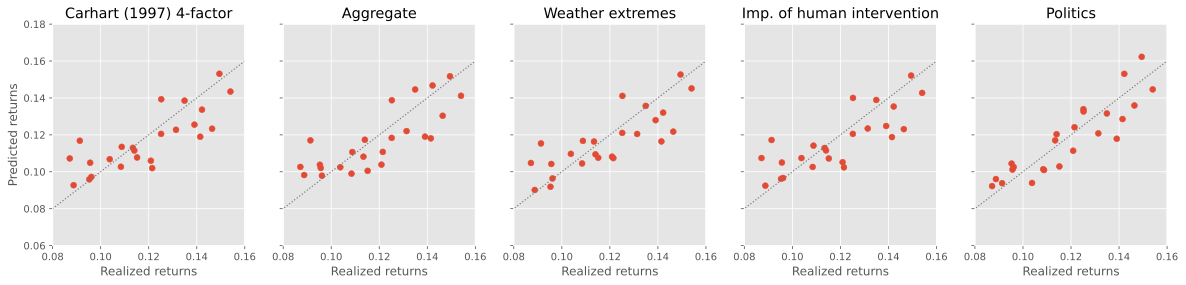

In [17]:

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, topic in enumerate(TOPICS):
    fm_objects[i].plot(ax=axes[i])

    axes[i].plot(np.linspace(0.05,0.2, 1000), np.linspace(0.05,0.2, 1000), color='C3', linestyle=':', linewidth=1.2)

    axes[i].set_title(names.get(topic))

    axes[i].set_xlabel('Realized returns')
    axes[i].set_xlim(0.08, 0.16)
    axes[i].set_ylim(0.06, 0.18)

axes[0].set_ylabel('Predicted returns')
#axes[0].set_ylim(0, 0.20)

fig.savefig(f"plots/fm_pred_vs_realized", dpi=450, bbox_inches="tight")

plt.show()